In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid
import holidays

In [2]:
cwd = os.getcwd()

def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MAE: {:.2f}'.format(mae))
    print('RMSE: {:.2f}'.format(rmse))
    print('')
    print('')
    return mae, rmse

In [3]:
sl = pd.read_csv('dataset/SCED (5m).csv')
sl['sced_time_stamp_local'] = pd.to_datetime(sl['sced_time_stamp_local'])
sl.set_index('sced_time_stamp_local', inplace=True)
sl = sl.resample('h').mean()
date_range = pd.date_range(start=sl.index.min(), end=sl.index.max(), freq='h')
sl = sl[~sl.index.duplicated(keep='first')]
sl = sl.reindex(date_range, fill_value=np.nan)
sl.interpolate(method='time', inplace=True)


In [4]:
dap = pd.read_csv('dataset/DAP (1hr).csv')
dap['timestamp'] = pd.to_datetime(dap['timestamp'])
dap.set_index('timestamp', inplace=True)
date_range = pd.date_range(start=dap.index.min(), end='2024-01-01 23:55:00', freq='h')
dap = dap[~dap.index.duplicated(keep='first')]
dap = dap.reindex(date_range, fill_value=np.nan)
dap.interpolate(method='time', inplace=True)

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_96799/1171035437.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dap['timestamp'] = pd.to_datetime(dap['timestamp'])


In [5]:
current_fuel = pd.read_csv('dataset/Fuel (5m).csv')
current_fuel['interval_start_local'] = pd.to_datetime(current_fuel['interval_start_local'])
current_fuel.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_fuel.index.min(), end='2024-01-01 23:55:00', freq='h')
current_fuel = current_fuel[~current_fuel.index.duplicated(keep='first')]
current_fuel = current_fuel.reindex(date_range, fill_value=np.nan)
current_fuel.interpolate(method='time', inplace=True)

In [6]:
current_fuel

,coal_and_lignite,hydro,nuclear,power_storage,solar,wind,natural_gas,other
2019-01-01 00:00:00,6116.419040,185.465296,3895.951940,0.0,0.0,14311.36445,12512.80815,2.534772
2019-01-01 01:00:00,6423.242360,186.667008,3894.973176,0.0,0.0,14298.52586,12434.13638,2.947464
2019-01-01 02:00:00,6309.280752,187.408832,3894.733152,0.0,0.0,14030.82875,12797.25831,-1.954544
2019-01-01 03:00:00,6416.671292,187.817564,3894.714576,0.0,0.0,13610.13937,13279.01803,1.887324
2019-01-01 04:00:00,6569.580884,186.990116,3892.748912,0.0,0.0,13414.14969,13585.26799,-0.201100
...,...,...,...,...,...,...,...,...
2024-01-01 19:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 20:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 21:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000
2024-01-01 22:00:00,5980.600000,0.000000,5115.500000,90.7,0.0,16842.90000,14118.70000,0.000000


In [7]:
current_renewables = current_fuel.copy()
current_renewables["renewable"] = (
    current_renewables["solar"] +
    current_renewables["hydro"] +
    current_renewables["wind"]
)
current_renewables = current_renewables[["renewable"]]


In [8]:
current_load = pd.read_csv('dataset/Load (5m).csv')
current_load['interval_start_local'] = pd.to_datetime(current_load['interval_start_local'])
current_load.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_load.index.min(), end='2024-01-01 23:55:00', freq='h')
current_load = current_load[~current_load.index.duplicated(keep='first')]
current_load = current_load.reindex(date_range, fill_value=np.nan)
current_load.interpolate(method='time', inplace=True)


In [9]:
current_nonrenew = pd.DataFrame()
current_nonrenew["non-renew"] = current_load["load"] - current_renewables["renewable"]

In [10]:
forecasted_tlf = pd.read_csv('dataset/FORECASTED_TLF (15m).csv')
forecasted_tlf['datetime'] = pd.to_datetime(forecasted_tlf['datetime'])
forecasted_tlf.set_index('datetime', inplace=True)
date_range = pd.date_range(start=forecasted_tlf.index.min(), end='2024-01-01 23:55:00', freq='h')
forecasted_tlf = forecasted_tlf[~forecasted_tlf.index.duplicated(keep='first')]
forecasted_tlf = forecasted_tlf.reindex(date_range, fill_value=np.nan)
forecasted_tlf.interpolate(method='time', inplace=True)


In [11]:
# Read the CSV file for natural gas prices
ng_price = pd.read_csv('dataset/NaturalGasPrice (1D).csv')

# Convert the 'datetime' column to datetime objects
ng_price['datetime'] = pd.to_datetime(ng_price['Date'])

# Set the 'datetime' column as the index
ng_price.set_index('datetime', inplace=True)

# Create an hourly date range from the minimum datetime up to '2024-01-01 23:55:00'
date_range = pd.date_range(start=ng_price.index.min(), end='2024-01-01 23:55:00', freq='h')

# Remove duplicated datetime entries, keeping the first occurrence
ng_price = ng_price[~ng_price.index.duplicated(keep='first')]

# Reindex the DataFrame to the hourly date range, filling missing entries with NaN
ng_price = ng_price.reindex(date_range, fill_value=np.nan)

# Interpolate missing values using time-based interpolation
ng_price.interpolate(method='time', inplace=True)
ng_price.drop(columns=['Date'], inplace=True)
ng_price

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_96799/2646805775.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ng_price.interpolate(method='time', inplace=True)


,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
1997-01-07 00:00:00,3.820000
1997-01-07 01:00:00,3.819167
1997-01-07 02:00:00,3.818333
1997-01-07 03:00:00,3.817500
1997-01-07 04:00:00,3.816667
...,...
2024-01-01 19:00:00,2.580000
2024-01-01 20:00:00,2.580000
2024-01-01 21:00:00,2.580000
2024-01-01 22:00:00,2.580000


In [12]:
# Prepare final dataframe
df = pd.concat([dap, sl, forecasted_tlf, ng_price, current_nonrenew], axis=1)

# Rename columns (adding Natural Gas at the end)
df.columns = ['DAP', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew']

df.dropna(inplace=True)

df

,DAP,SCED,F_TLF,NG Price,Non-Renew
2019-01-02 00:00:00,23.9250,26.216109,0.016499,3.250000,36508.703164
2019-01-02 01:00:00,23.3140,25.671136,0.016441,3.227917,35983.092128
2019-01-02 02:00:00,23.3475,24.970952,0.016411,3.205833,35550.176684
2019-01-02 03:00:00,23.0595,24.787712,0.016441,3.183750,35511.693684
2019-01-02 04:00:00,25.2672,24.887786,0.016534,3.161667,36565.635248
...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,14.422107,0.021356,2.580000,29417.400000
2023-12-31 20:00:00,16.7739,12.597410,0.021367,2.580000,26543.200000
2023-12-31 21:00:00,15.0035,10.170172,0.021383,2.580000,24706.800000
2023-12-31 22:00:00,15.7699,9.872549,0.021408,2.580000,23992.100000


In [13]:

import holidays

# Get official Texas holidays
tx_holidays = holidays.US(state='TX')  # includes state + federal holidays observed in Texas

# Add holiday indicator to your DataFrame (assumes datetime index)
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x.date() in tx_holidays else 0)

df

,DAP,SCED,F_TLF,NG Price,Non-Renew,is_holiday
2019-01-02 00:00:00,23.9250,26.216109,0.016499,3.250000,36508.703164,0
2019-01-02 01:00:00,23.3140,25.671136,0.016441,3.227917,35983.092128,0
2019-01-02 02:00:00,23.3475,24.970952,0.016411,3.205833,35550.176684,0
2019-01-02 03:00:00,23.0595,24.787712,0.016441,3.183750,35511.693684,0
2019-01-02 04:00:00,25.2672,24.887786,0.016534,3.161667,36565.635248,0
...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,14.422107,0.021356,2.580000,29417.400000,0
2023-12-31 20:00:00,16.7739,12.597410,0.021367,2.580000,26543.200000,0
2023-12-31 21:00:00,15.0035,10.170172,0.021383,2.580000,24706.800000,0
2023-12-31 22:00:00,15.7699,9.872549,0.021408,2.580000,23992.100000,0


In [14]:
# compute rolling mean & std
df['mu_24h'] = df['DAP'].rolling(24, min_periods=1).mean()
df['std_24h'] = df['DAP'].rolling(24, min_periods=1).std().fillna(0)

k = 2.0
df['is_spike'] = (df['DAP'] > df['mu_24h'] + k * df['std_24h']).astype(int)

# for regression target, only care about magnitude above threshold
df['spike_mag'] = np.where(df['is_spike'] == 1,
                           df['DAP'] - df['mu_24h'],
                           0.0)

df.drop(['mu_24h', 'std_24h'], axis=1, inplace=True)
df

,DAP,SCED,F_TLF,NG Price,Non-Renew,is_holiday,is_spike,spike_mag
2019-01-02 00:00:00,23.9250,26.216109,0.016499,3.250000,36508.703164,0,0,0.0
2019-01-02 01:00:00,23.3140,25.671136,0.016441,3.227917,35983.092128,0,0,0.0
2019-01-02 02:00:00,23.3475,24.970952,0.016411,3.205833,35550.176684,0,0,0.0
2019-01-02 03:00:00,23.0595,24.787712,0.016441,3.183750,35511.693684,0,0,0.0
2019-01-02 04:00:00,25.2672,24.887786,0.016534,3.161667,36565.635248,0,0,0.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,14.422107,0.021356,2.580000,29417.400000,0,0,0.0
2023-12-31 20:00:00,16.7739,12.597410,0.021367,2.580000,26543.200000,0,0,0.0
2023-12-31 21:00:00,15.0035,10.170172,0.021383,2.580000,24706.800000,0,0,0.0
2023-12-31 22:00:00,15.7699,9.872549,0.021408,2.580000,23992.100000,0,0,0.0


In [15]:
# total number of spikes
n_spikes = df['is_spike'].sum()
print(f"Found {n_spikes} spikes out of {len(df)} rows.")

# breakdown by class
vc = df['is_spike'].value_counts().rename({0:'non‑spike', 1:'spike'})
print(vc)

# if you want the % of spikes
pct = df['is_spike'].mean() * 100
print(f"Spikes are {pct:.2f}% of your data.")

Found 2805 spikes out of 43800 rows.
is_spike
non‑spike    40995
spike         2805
Name: count, dtype: int64
Spikes are 6.40% of your data.


In [16]:
## log transform
log_data = df.copy(deep=True)

columns_to_log = ['DAP', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew', 'is_spike', 'spike_mag']

offsets = {}           # column → min value
for col in columns_to_log:
    offsets[col] = df[col].min()
    log_data[col] = np.log(df[col] - offsets[col] + 1)


In [17]:
feature_cols = ['DAP', 'SCED', 'F_TLF', 'NG Price', 'Non-Renew',
                'is_holiday']

# classification target comes from the original df:
cls_target = df['is_spike']
# regression target is the log‐transformed spike magnitude:
reg_target = log_data['spike_mag']

In [18]:
train_mask = (log_data.index <= '2021-12-31 23:55:00')
val_mask   = (log_data.index >= '2022-01-01') & (log_data.index <= '2022-12-31 23:55:00')
test_mask  = (log_data.index >= '2023-01-01')

# slice out
X = log_data[feature_cols]
y_cls = cls_target
y_reg = reg_target

X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
y_train_cls, y_val_cls, y_test_cls = y_cls[train_mask], y_cls[val_mask], y_cls[test_mask]
y_train_reg, y_val_reg, y_test_reg = y_reg[train_mask], y_reg[val_mask], y_reg[test_mask]


In [19]:
# 3) === standardize inputs ===
x_mean, x_std = X_train.mean(), X_train.std()+1e-6
X_train_std = (X_train - x_mean) / x_std
X_val_std   = (X_val   - x_mean) / x_std
X_test_std  = (X_test  - x_mean) / x_std

In [20]:
# after your standardization…
X_tr = X_train_std.values
X_va = X_val_std.values
X_te = X_test_std.values

y_tr_cls = y_train_cls.values
y_va_cls = y_val_cls.values
y_te_cls = y_test_cls.values

y_tr_reg = y_train_reg.values
y_va_reg = y_val_reg.values
y_te_reg = y_test_reg.values


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, final_act=None):
        super().__init__()
        layers = []
        for i in range(len(layer_sizes)-1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                layers.append(nn.ReLU())
        if final_act is not None:
            layers.append(final_act)
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

In [23]:
def run_config(cfg, Xtr, ytr, Xva, yva, is_cls):
    # build model
    in_dim = Xtr.shape[1]
    final_act = nn.Sigmoid() if is_cls else None
    sizes = [in_dim, *cfg['hidden_sizes'], 1]
    model = MLP(sizes, final_act).to(device)

    # DataLoaders
    ytr_t = torch.from_numpy(ytr).float().unsqueeze(1)
    yva_t = torch.from_numpy(yva).float().unsqueeze(1)
    ds_tr = TensorDataset(torch.from_numpy(Xtr).float(), ytr_t)
    ds_va = TensorDataset(torch.from_numpy(Xva).float(), yva_t)
    dl_tr = DataLoader(ds_tr, batch_size=cfg['batch_size'], shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=cfg['batch_size'])

    # loss & optimizer
    loss_fn = nn.BCELoss() if is_cls else nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=cfg['lr'])

    # training
    for _ in range(cfg['epochs']):
        model.train()
        for xb,yb in dl_tr:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward(); opt.step()

    # validation
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb,yb in dl_va:
            xb,yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += loss_fn(pred, yb).item() * xb.size(0)
            if is_cls:
                correct += ((pred>0.5).float()==yb).sum().item()
            total += xb.size(0)

    if is_cls:
        return correct/total           # accuracy
    else:
        mse = total_loss/total
        return np.sqrt(mse)            # RMSE (log‑scale)

In [24]:
# 1) set up your hyperparameter grid
param_grid = {
    'hidden_sizes': [[64], [128], [64,32], [128,64]],
    'lr':           [1e-3, 1e-4],
    'batch_size':   [64,128],
    'epochs':       [20]
}

In [25]:
# 2) grid‐search for the **classifier**
best_acc, best_cfg_cls = 0.0, None
for cfg in ParameterGrid(param_grid):
    acc = run_config(cfg, X_tr, y_tr_cls, X_va, y_va_cls, is_cls=True)
    if acc > best_acc:
        best_acc, best_cfg_cls = acc, cfg
print(">> Best classifier config:", best_cfg_cls, "Val Acc:", best_acc)

>> Best classifier config: {'batch_size': 64, 'epochs': 20, 'hidden_sizes': [128, 64], 'lr': 0.0001} Val Acc: 0.9440639269406392


In [26]:
# 3) grid‐search for the **regressor**
best_rmse, best_cfg_reg = float('inf'), None
for cfg in ParameterGrid(param_grid):
    rmse = run_config(cfg, X_tr, y_tr_reg, X_va, y_va_reg, is_cls=False)
    if rmse < best_rmse:
        best_rmse, best_cfg_reg = rmse, cfg
print(">> Best regressor config:", best_cfg_reg, "Val RMSE:", best_rmse)


>> Best regressor config: {'batch_size': 128, 'epochs': 20, 'hidden_sizes': [64, 32], 'lr': 0.001} Val RMSE: 0.8575861410053729


In [30]:
# 4) retrain each on train+val, then eval on test
def retrain_and_eval(cfg, Xtrain, ytrain, Xtest, ytest, is_cls):
    Xfull = np.vstack([Xtrain, X_va])
    yfull = np.concatenate([ytrain, y_va_cls if is_cls else y_va_reg])
    return run_config(cfg, Xfull, yfull, Xtest, ytest, is_cls)

test_acc       = retrain_and_eval(best_cfg_cls, X_tr, y_tr_cls, X_te, y_te_cls, True)
test_rmse_log  = retrain_and_eval(best_cfg_reg, X_tr, y_tr_reg, X_te, y_te_reg, False)
print(f">> Final Test — Classifier Acc: {test_acc:.3f}")
print(f">> Final Test — Regressor RMSE (log‑scale): {test_rmse_log:.3f}")

>> Final Test — Classifier Acc: 0.905
>> Final Test — Regressor RMSE (log‑scale): 0.969


In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# y_true and y_pred as NumPy arrays of 0/1
y_true = y_te_cls
y_pred = pred_labels

# 1. Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# 2. Standard metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 score : {f1:.3f}")


TN: 7485, FP: 663, FN: 173, TP: 439
Accuracy : 0.905
Precision: 0.398
Recall   : 0.717
F1 score : 0.512


In [31]:

# 1) Rebuild & retrain the final regressor on train+val
# ----------------------------------------------------
in_dim = X_tr.shape[1]
final_reg = MLP([in_dim, *best_cfg_reg['hidden_sizes'], 1], final_act=None).to(device)

# full train+val data
X_full   = np.vstack([X_tr,   X_va])
y_full   = np.concatenate([y_tr_reg, y_va_reg])   # still log‑scale target

# dataloader
bs = best_cfg_reg['batch_size']
ds_full = TensorDataset(torch.from_numpy(X_full).float(),
                        torch.from_numpy(y_full).float().unsqueeze(1))
loader_full = DataLoader(ds_full, batch_size=bs, shuffle=True)

# optimizer + loss
opt = torch.optim.Adam(final_reg.parameters(), lr=best_cfg_reg['lr'])
loss_fn = nn.MSELoss()

# train  
for _ in range(best_cfg_reg['epochs']):
    final_reg.train()
    for xb, yb in loader_full:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = final_reg(xb)
        loss_fn(pred, yb).backward()
        opt.step()

# 2) Run it on your test set to get preds_log
# --------------------------------------------
final_reg.eval()
with torch.no_grad():
    X_te_t  = torch.from_numpy(X_te).float().to(device)
    preds_log = final_reg(X_te_t).cpu().numpy().flatten()

# 3) Grab the true magnitudes from your original df
# ---------------------------------------------------
actual_mag = df['spike_mag'][test_mask].values   # in MW

# 4) Compute true MW‐scale RMSE (and MAE) in one shot
# ---------------------------------------------------
test_rmse_mw = np.sqrt(np.mean((np.expm1(preds_log) - actual_mag)**2))
test_mae_mw  = np.mean(np.abs(np.expm1(preds_log) - actual_mag))

print(f"Test Regression — MAE: {test_mae_mw:.2f} MW,  RMSE: {test_rmse_mw:.2f} MW")

Test Regression — MAE: 13.85 MW,  RMSE: 104.15 MW


In [34]:
preds_mag  = np.expm1(preds_log)
actual_mag = df['spike_mag'][test_mask].values

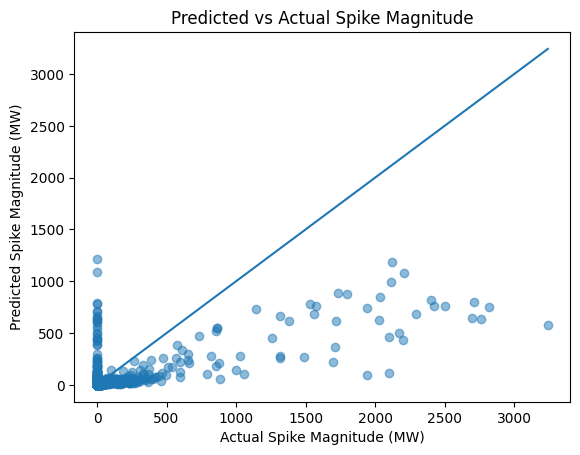

In [35]:
plt.figure()
plt.scatter(actual_mag, preds_mag, alpha=0.5)
mn = min(actual_mag.min(), preds_mag.min())
mx = max(actual_mag.max(), preds_mag.max())
plt.plot([mn, mx], [mn, mx])            # 45° line
plt.xlabel('Actual Spike Magnitude (MW)')
plt.ylabel('Predicted Spike Magnitude (MW)')
plt.title('Predicted vs Actual Spike Magnitude')
plt.show()

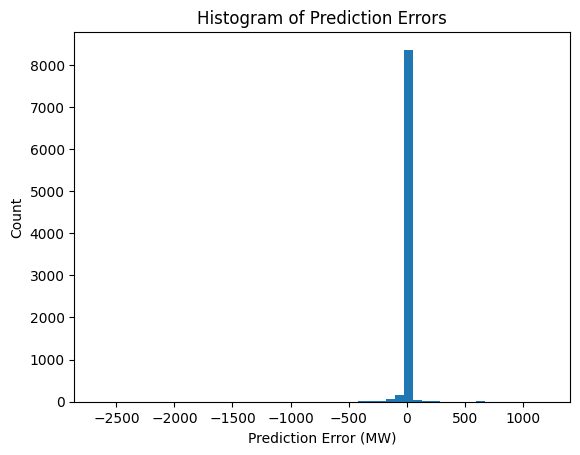

In [36]:
errors = preds_mag - actual_mag

plt.figure()
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error (MW)')
plt.ylabel('Count')
plt.title('Histogram of Prediction Errors')
plt.show()


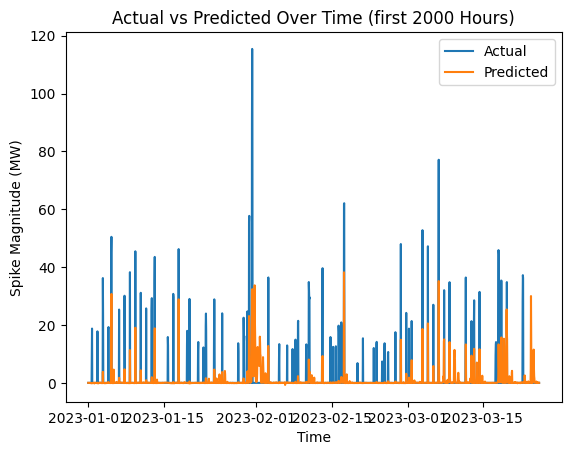

In [44]:
# pick N points (e.g. first 200 hours of your test set)
N = 2000
times = df.index[test_mask][:N]

plt.figure()
plt.plot(times, actual_mag[:N])
plt.plot(times, preds_mag[:N])
plt.xlabel('Time')
plt.ylabel('Spike Magnitude (MW)')
plt.title(f'Actual vs Predicted Over Time (first {N} Hours)')
plt.legend(['Actual','Predicted'])
plt.show()


In [47]:
def train_epoch(model, loader, optim, loss_fn, device):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optim.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, loss_fn, is_cls, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += loss_fn(pred, yb).item() * xb.size(0)
            if is_cls:
                correct += ((pred>0.5).float() == yb).sum().item()
            total += xb.size(0)
    avg_loss = total_loss / total
    return (avg_loss, correct/total) if is_cls else avg_loss

In [48]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 1) Rebuild & retrain final classifier on train+val
in_dim = X_tr.shape[1]
final_clf = MLP(
    [in_dim, *best_cfg_cls['hidden_sizes'], 1],
    final_act=nn.Sigmoid()
).to(device)

# Prepare train+val data
X_full_cls = np.vstack([X_tr, X_va])
y_full_cls = np.concatenate([y_tr_cls, y_va_cls])

ds_full_cls = TensorDataset(
    torch.from_numpy(X_full_cls).float(),
    torch.from_numpy(y_full_cls).float().unsqueeze(1)
)
loader_full_cls = DataLoader(ds_full_cls,
                             batch_size=best_cfg_cls['batch_size'],
                             shuffle=True)

opt_clf = torch.optim.Adam(final_clf.parameters(), lr=best_cfg_cls['lr'])
loss_fn  = nn.BCELoss()

for _ in range(best_cfg_cls['epochs']):
    train_epoch(final_clf, loader_full_cls, opt_clf, loss_fn, device)

# 2) Run it on the test set
final_clf.eval()
with torch.no_grad():
    X_te_t = torch.from_numpy(X_te).float().to(device)
    probs  = final_clf(X_te_t).cpu().numpy().flatten()

# 3) Threshold and count
pred_labels = (probs > 0.5).astype(int)
n_predicted_spikes = pred_labels.sum()
n_actual_spikes    = int(y_te_cls.sum())

print(f"Predicted spikes (test set): {n_predicted_spikes}")
print(f"Actual    spikes (test set): {n_actual_spikes}")


Predicted spikes (test set): 1102
Actual    spikes (test set): 612
